# Yankees 2023 — Rolling xwOBA & Comparable Players

This notebook does two things:

1. **Rolling xwOBA** per hitter for the New York Yankees in **2023** (from pitch-level Statcast).
2. **Comparable players** using **cosine similarity** on **season-level** features.

It is designed to run inside this repo:
- Looks for raw Statcast in `data/raw/` (e.g., `statcast_NYY_2023.csv` or `statcast_ALL_2023.csv`).
- Falls back to `sample_data/` when possible.
- If raw is missing, you can (optionally) fetch via `pybaseball` in the cell below.

In [2]:
# Setup
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw"
PROC_DIR = DATA_DIR / "processed"
SAMPLE_DIR = Path("sample_data")

TEAM = "NYY"
YEAR = 2023

plt.rcParams["figure.figsize"] = (10, 5)

## Locate raw Statcast for 2023

We try, in order:
1) `data/raw/statcast_NYY_2023.csv`  
2) any `data/raw/statcast_*_2023.csv` (league-wide or other team)  
3) `sample_data/` fallback (if provided)

If none exist, run the **optional fetch cell** to download via `pybaseball` (local-only).

In [28]:
# Find a suitable raw CSV for 2023
raw_path = None
preferred = RAW_DIR / f"statcast_{TEAM}_{YEAR}.csv"
if preferred.exists():
    raw_path = preferred
else:
    cands = sorted(RAW_DIR.glob(f"statcast_*_{YEAR}.csv"))
    raw_path = cands[0] if cands else None

raw_path

### (Optional) Fetch via `pybaseball` if raw is missing

> This requires internet access and will write to `data/raw/` using monthly chunks (friendly to the source).

In [29]:
# # OPTIONAL: Fetch raw 2023 for NYY if not present
# # Uncomment and run if needed.
# from pybaseball import statcast
# import pandas as pd
# from datetime import date
# RAW_DIR.mkdir(parents=True, exist_ok=True)
# months = [(3,31),(4,30),(5,31),(6,30),(7,31),(8,31),(9,30),(10,31)]
# frames = []
# for m, last_day in months:
#     start = f"{YEAR}-{m:02d}-01"
#     end   = f"{YEAR}-{m:02d}-{last_day:02d}"
#     print("Fetching", start, "→", end)
#     df = statcast(start_dt=start, end_dt=end, team=TEAM)
#     frames.append(df)
# raw = pd.concat(frames, ignore_index=True)
# outp = RAW_DIR / f"statcast_{TEAM}_{YEAR}.csv"
# raw.to_csv(outp, index=False)
# raw_path = outp
# raw_path

## Load raw with minimal columns

Using `usecols` keeps I/O fast and the notebook portable.

In [35]:
raw_path = 'c:/Users/mvali/Documents/Employment/teamworks-intelligence-ml-yankees/data/raw/statcast_NYY_2023.csv'

In [36]:
usecols = [
    "game_date","game_pk","at_bat_number",
    "batter","player_name","batter_name","batter_full_name",
    "estimated_woba_using_speedangle","woba_value","woba_denom",
    "events"
]

if raw_path:
    header = pd.read_csv(raw_path, nrows=0).columns.tolist()
    cols = [c for c in usecols if c in header]
    sc = pd.read_csv(raw_path, usecols=cols, low_memory=False)
else:
    # try a small fallback (optional)
    sc = pd.DataFrame()

print("Raw Statcast shape:", sc.shape)
display(sc.head(3))

Raw Statcast shape: (25805, 9)


,game_date,player_name,batter,events,game_pk,estimated_woba_using_speedangle,woba_value,woba_denom,at_bat_number
0,2023-03-30,"Marinaccio, Ron",642731,strikeout,718781,0.0,0.0,1.0,67
1,2023-03-30,"Marinaccio, Ron",642731,NaN,718781,NaN,NaN,NaN,67
2,2023-03-30,"Marinaccio, Ron",642731,NaN,718781,NaN,NaN,NaN,67


## Build PA-level table & compute rolling xwOBA

- **PA** defined as unique `(game_pk, at_bat_number)` with a non-null `events` value.
- Rolling average uses `estimated_woba_using_speedangle` as a proxy for xwOBA.

In [41]:
# Resolve columns
name_col = next((c for c in ["player_name","batter_name","batter_full_name"] if c in sc.columns), None)
id_col   = next((c for c in ["batter","batter_id","batter_pk"] if c in sc.columns), None)
if name_col is None:
    name_col = "player_name"
    sc[name_col] = "UNKNOWN"
if id_col is None:
    sc["__pid__"] = sc[name_col].fillna("UNKNOWN").astype("category").cat.codes
    id_col = "__pid__"

# Filter to rows with events and a date
sc["game_date"] = pd.to_datetime(sc.get("game_date", pd.NaT), errors="coerce")
mask_evt = sc["events"].notna() if "events" in sc.columns else False
df = sc.loc[mask_evt].dropna(subset=["game_date"]).copy()

# Unique ABs
ab = df[["game_pk","at_bat_number","estimated_woba_using_speedangle", id_col, name_col, "game_date"]].drop_duplicates()
ab = ab.sort_values(["game_date", id_col, "at_bat_number"]).reset_index(drop=True)

# Top hitters by PA
top = (ab.groupby([id_col, name_col]).size().rename("PA")
         .reset_index().sort_values("PA", ascending=False).head(8))
top

,batter,player_name,PA
2235,666182,"Cole, Gerrit",14
327,543807,"Cole, Gerrit",14
1999,664040,"Cole, Gerrit",12
1553,656305,"Cole, Gerrit",12
2318,668227,"Cole, Gerrit",12
1678,657077,"Schmidt, Clarke",11
600,593160,"Cole, Gerrit",11
2653,670623,"Cole, Gerrit",11


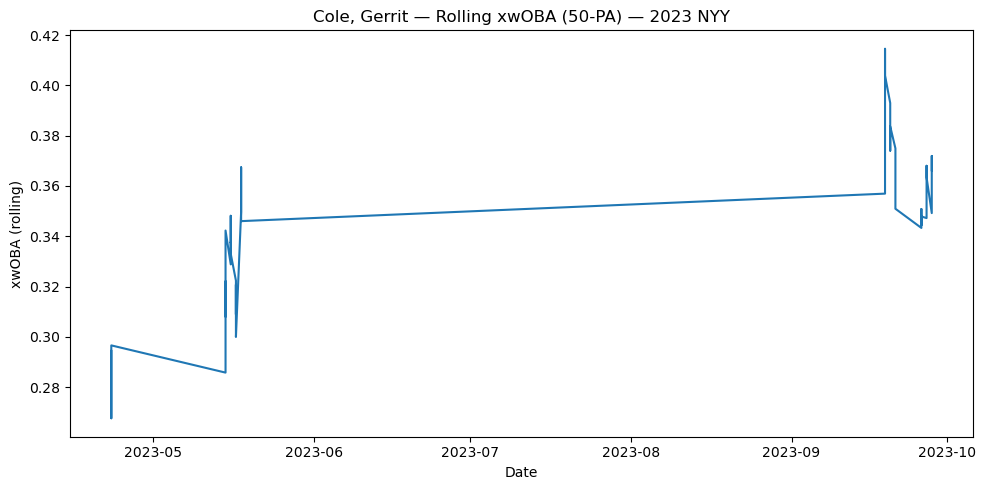

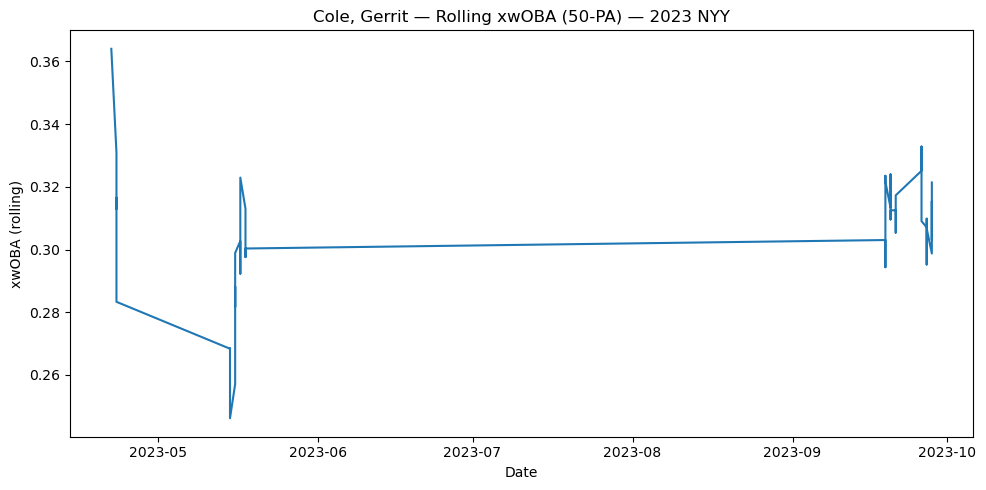

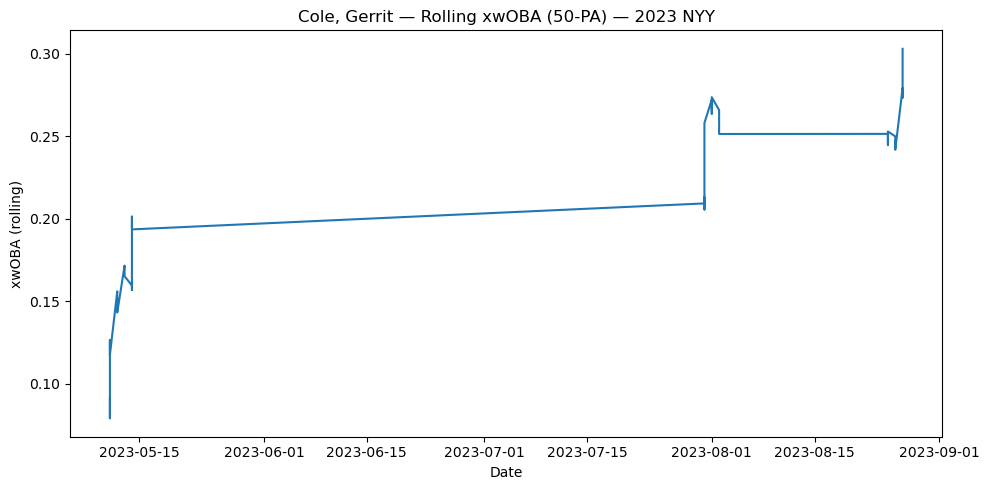

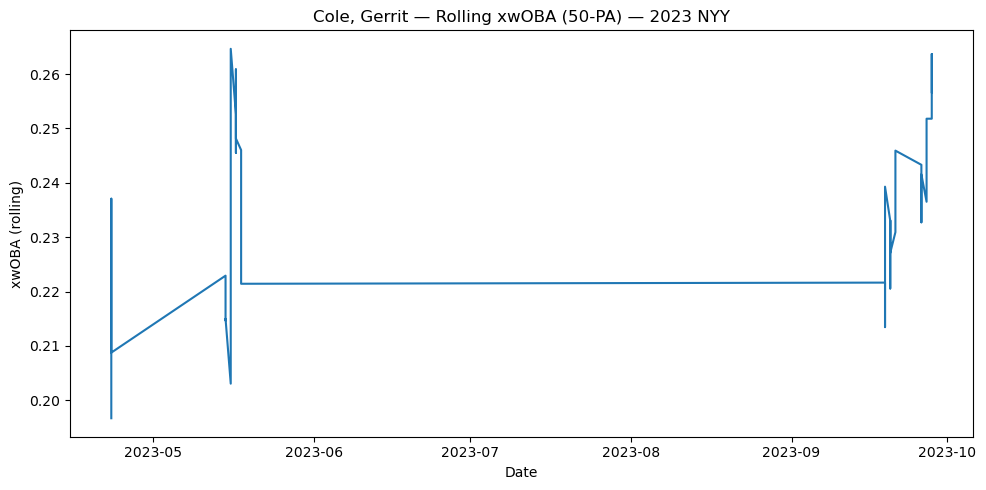

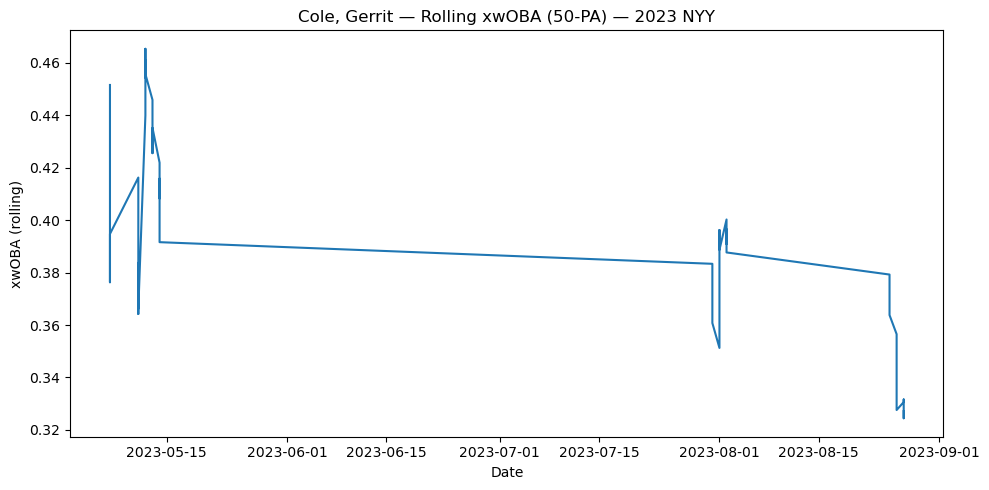

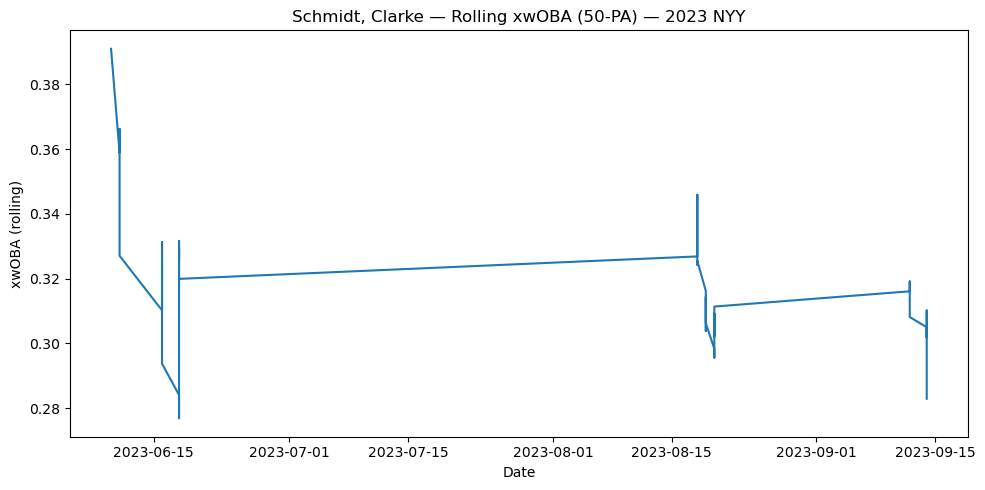

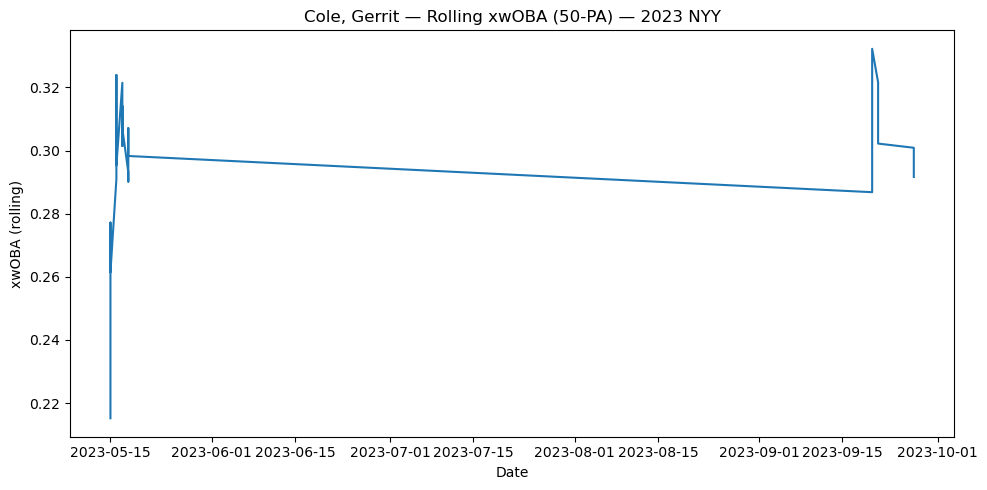

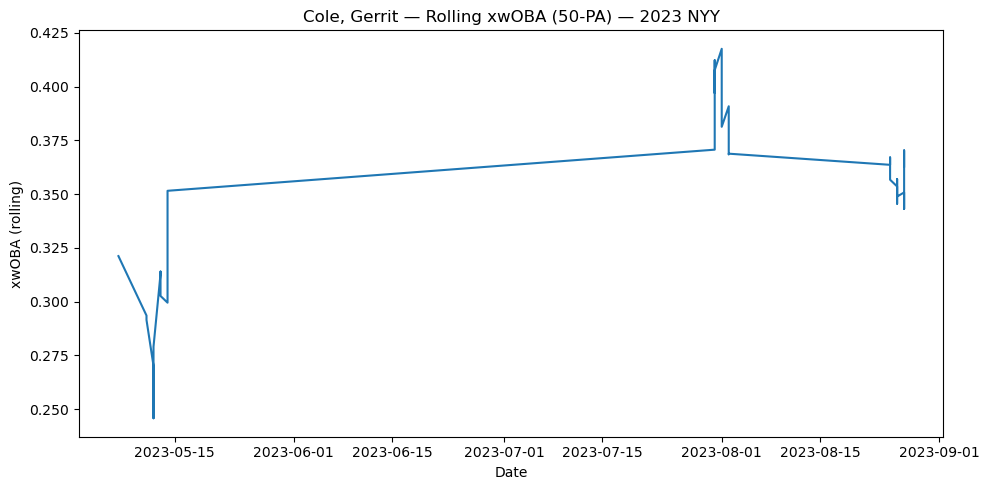

In [42]:
# Plot rolling xwOBA for top hitters
ROLL = 50  # window in PAs (adjust if you prefer 25 or 75)
for pid, pname in top[[id_col, name_col]].itertuples(index=False):
    sub = ab[ab[id_col] == pid].copy()
    x = sub["estimated_woba_using_speedangle"]
    rolling = x.rolling(ROLL, min_periods=max(5, ROLL//5)).mean()
    plt.figure()
    plt.plot(sub["game_date"], rolling)
    plt.title(f"{pname} — Rolling xwOBA ({ROLL}-PA) — {YEAR} {TEAM}")
    plt.xlabel("Date"); plt.ylabel("xwOBA (rolling)")
    plt.tight_layout(); plt.show()

## Comparable players (season-level features)

We compute **cosine similarity** on standardized vectors using features:
- `xwoba`, `avg_ev`, `k_rate`, `bb_rate`, `barrel_rate`

Source: `data/processed/hitters_features.csv` (or `sample_data/hitters_features_sample.csv`).

In [ ]:
# Load season-level features
hit_path = PROC_DIR / "hitters_features.csv"
if not hit_path.exists():
    alt_path = Path("sample_data") / "hitters_features_sample.csv"
    hit_path = alt_path if alt_path.exists() else None

if hit_path and Path(hit_path).exists():
    hit = pd.read_csv(hit_path)
    if "season" in hit.columns:
        hit["season"] = pd.to_numeric(hit["season"], errors="coerce").astype("Int64")
else:
    hit = pd.DataFrame()

print("Season-level features shape:", hit.shape)
display(hit.head(3))

Season-level features shape: (1322, 11)


,player_id,player_name,season,pa,woba,xwoba,avg_ev,max_ev,k_rate,bb_rate,barrel_rate
0,543063,"Kuhl, Chad",2022,10.0,1.150000,0.324750,86.963636,101.4,0.1,0.0,NaN
1,592518,"Kuhl, Chad",2022,11.0,0.918182,0.594545,88.609524,110.1,0.0,0.0,NaN
2,669257,"Clevinger, Mike",2022,10.0,0.900000,0.621221,86.346667,110.6,0.0,0.1,NaN


In [50]:
# Build similarity on latest season available
features = ["xwoba","avg_ev","k_rate","bb_rate"]
dfc = hit.dropna(subset=features).copy()
for c in features:
    dfc[c] = pd.to_numeric(dfc[c], errors="coerce")
dfc = dfc.dropna(subset=features)

if not dfc.empty:
    latest = int(dfc["season"].dropna().max())
    pool = dfc[dfc["season"] == latest].copy()
    # choose a target by highest PA
    pool["pa"] = pd.to_numeric(pool.get("pa", np.nan), errors="coerce")
    tgt = pool.sort_values("pa", ascending=False).head(1)
    if not tgt.empty:
        from sklearn.preprocessing import StandardScaler
        from sklearn.metrics.pairwise import cosine_similarity
        X = dfc[features].values
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)
        sim = cosine_similarity(Xs)

        idx = tgt.index[0]
        s = pd.Series(sim[idx], index=dfc.index, name="similarity").sort_values(ascending=False)
        comps = (dfc.loc[s.index, ["player_name","season"] + features]
                   .assign(similarity=s.values)
                   .head(10)
                   .reset_index(drop=True))
        print("Target:", dfc.loc[idx, ["player_name","season"]].to_dict())
        display(comps.style.format({"similarity": "{:.3f}"}))
else:
    print("No season-level features found. Run the pipeline to create data/processed/hitters_features.csv.")

Target: {'player_name': 'Cortes, Nestor', 'season': 2024}


,player_name,season,xwoba,avg_ev,k_rate,bb_rate,similarity
0,"Cortes, Nestor",2024,0.484084,88.161111,0.200000,0.133333,1.000
1,"Urquidy, José",2022,0.539291,90.341667,0.166667,0.166667,0.993
2,"Singer, Brady",2022,0.441721,86.394737,0.200000,0.100000,0.985
3,"Valdez, Framber",2023,0.500346,89.550000,0.181818,0.181818,0.978
4,"Lynch IV, Daniel",2022,0.543014,87.782609,0.176471,0.176471,0.972
5,"Heaney, Andrew",2024,0.611387,91.225000,0.090909,0.181818,0.967
6,"Gausman, Kevin",2024,0.862232,93.345455,0.300000,0.200000,0.966
7,"Spence, Mitch",2024,0.427194,86.862500,0.181818,0.090909,0.961
8,"Quintana, Jose",2024,0.377199,85.486667,0.181818,0.090909,0.958
9,"Lodolo, Nick",2024,0.418819,88.036364,0.200000,0.100000,0.956


> **Tip:** If you want comps restricted to Yankees: filter `dfc` to `team == 'NYY'` once you add a team column during feature building.